In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, UpSampling2D, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from google.colab import drive
import zipfile

In [8]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
def load_data(image_dir="/content/drive/MyDrive/unet/all_images/images", mask_dir="/content/drive/MyDrive/unet/all_masks/masks", img_size=(224, 224)):
    images, masks = [], []
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_name, mask_name in zip(image_filenames, mask_filenames):
        img = load_img(os.path.join(image_dir, img_name), target_size=img_size)
        mask = load_img(os.path.join(mask_dir, mask_name), target_size=img_size, color_mode="grayscale")

        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)

    return np.array(images), np.array(masks)

In [9]:
def plot_sample(image, mask):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap="gray")  # Ensure grayscale mask
    plt.title("Mask")
    plt.axis("off")

    plt.show()

In [10]:
def ConvBlock(x, filters, dropout):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    return x

def AttentionBlock(x, g):
    attn = Conv2D(1, 1, activation='sigmoid')(g)
    return Multiply()([x, attn])

def UpSampleBlock(x, skip, filters, dropout):
    x = UpSampling2D()(x)
    x = Concatenate()([x, AttentionBlock(skip, x)])
    x = ConvBlock(x, filters, dropout)
    return x

In [11]:
def UNet(input_shape=(224, 224, 3), dropout=0.1, filters=[32, 64, 128, 256, 512]):
    inputs = Input(input_shape)

    c1 = ConvBlock(inputs, filters[0], dropout)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = ConvBlock(p1, filters[1], dropout)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = ConvBlock(p2, filters[2], dropout)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    c4 = ConvBlock(p3, filters[3], dropout)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = ConvBlock(p4, filters[4], dropout)

    u6 = UpSampleBlock(c5, c4, filters[3], dropout)
    u7 = UpSampleBlock(u6, c3, filters[2], dropout)
    u8 = UpSampleBlock(u7, c2, filters[1], dropout)
    u9 = UpSampleBlock(u8, c1, filters[0], dropout)

    outputs = Conv2D(1, 1, activation='sigmoid')(u9)

    return Model(inputs, outputs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


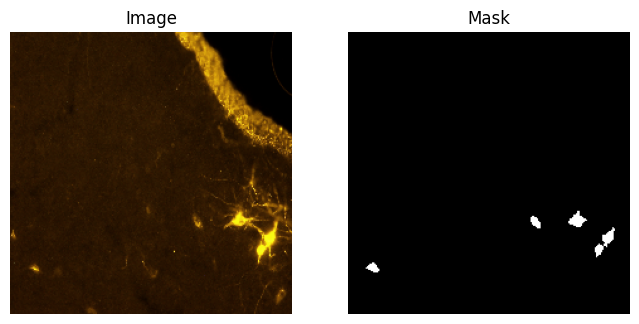

In [12]:
# Mount Google Drive
drive.mount('/content/drive')

# Define path to the zip file in Google Drive
zip_path = "/content/drive/MyDrive/archive.zip"
extract_to = "/content/drive/MyDrive/unet"

# Extract dataset
extract_zip(zip_path, extract_to)

# Load dataset
images, masks = load_data()

# Split dataset into training and validation sets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Plot a sample image and mask
plot_sample(images[0], masks[0])

In [13]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 256)    │          1,024 │ dropout_3[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 3,926,021 (14.98 MB)

 Trainable params: 3,923,077 (14.97 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [14]:
history = model.fit(np.array(train_imgs), np.array(train_masks),
                    batch_size=8,
                    epochs=20,
                    validation_data=(np.array(test_imgs), np.array(test_masks)))

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 881ms/step - accuracy: 0.6027 - loss: -29.2165 - val_accuracy: 0.0073 - val_loss: -7.9646
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6864 - loss: -55.8202 - val_accuracy: 0.0351 - val_loss: -3.3619
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6152 - loss: -71.8652 - val_accuracy: 0.2475 - val_loss: -3.6141
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.5435 - loss: -86.6134 - val_accuracy: 0.9901 - val_loss: -1.8850
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.4880 - loss: -105.9573 - val_accuracy: 0.8471 - val_loss: 0.2405
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4066 - loss: -114.5322 - val_accuracy: 0.9926 - val_loss: 19.4297
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.3293 - loss: -121.0445 - val_accuracy: 0.9926 - val_loss: 16.5768
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2887 - loss: -

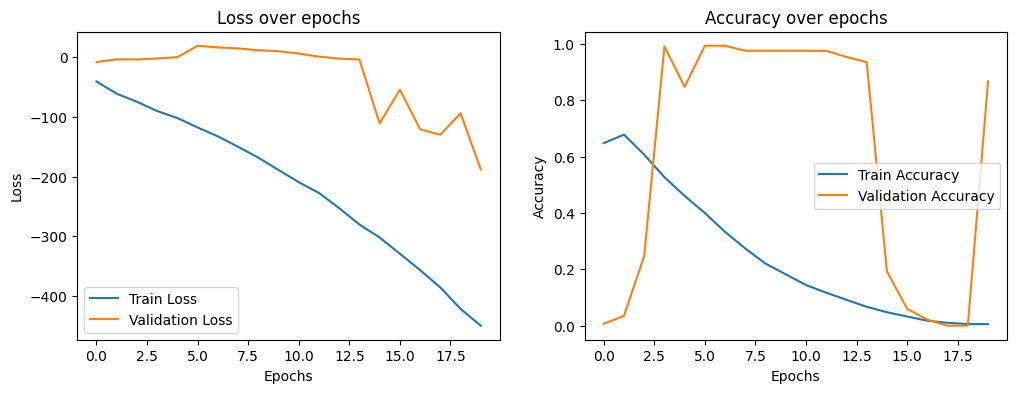

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step


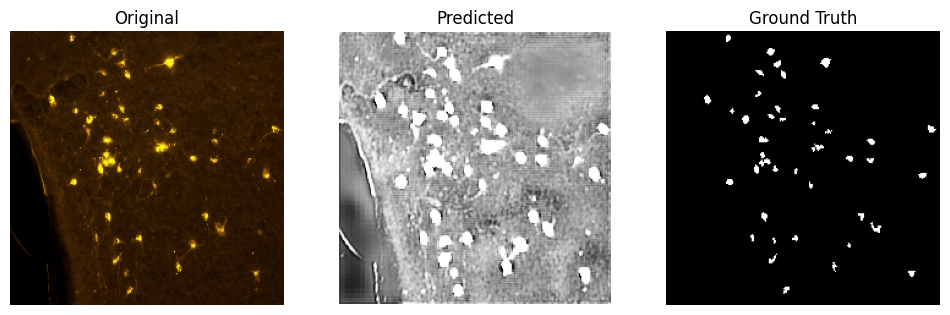

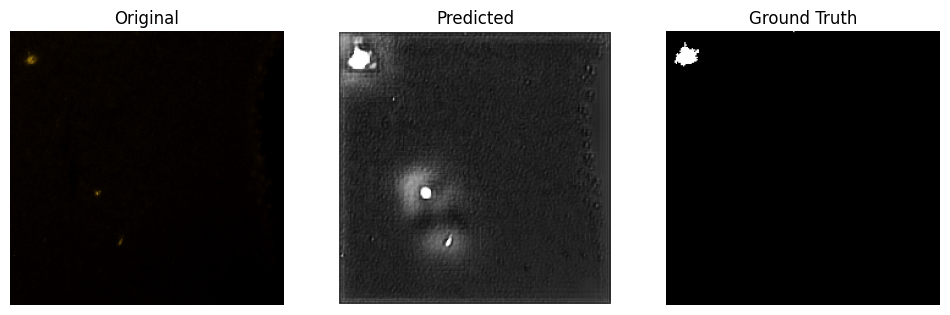

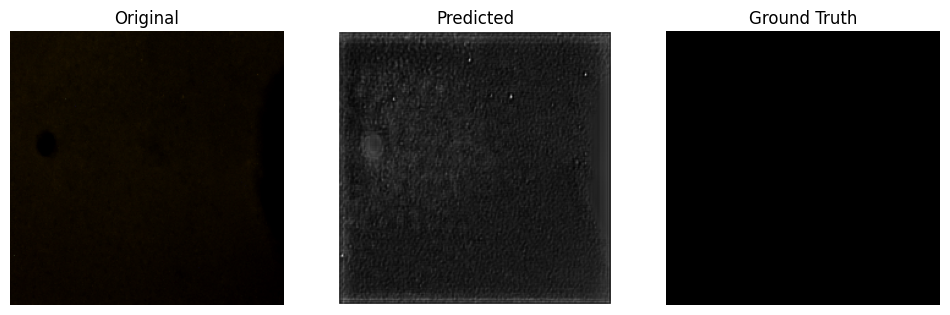

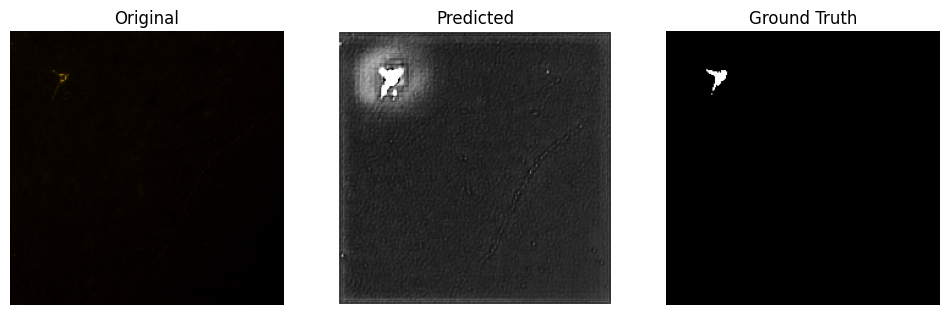

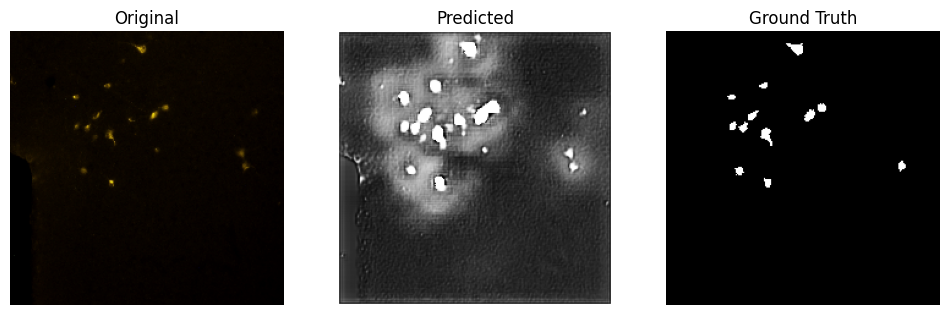

In [16]:
images_predict = model.predict(np.array(test_imgs))

def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize=(12, 7))

    ax[0].set_title('Original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('Predicted')
    ax[1].imshow(images_predict[id].squeeze(), cmap='gray')
    ax[1].axis("off")

    ax[2].set_title('Ground Truth')
    ax[2].imshow(test_masks[id].squeeze(), cmap='gray')
    ax[2].axis("off")

    plt.show()

# Show results for first 5 test images
for id in range(5):
    show_result(id)